# Bibliotheken

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
from sklearn.ensemble import IsolationForest

# 1. Daten aus CSV-File in Datenbank speichern

In [34]:
# Pfad zur CSV-Datei
csv_file_path = 'Daten.csv'

# Lese die CSV-Datei mit Semikolon als Trennzeichen
data = pd.read_csv(csv_file_path, sep=';')

# Zeige Informationen über die Daten an
print("\nInformationen zum Datensatz:")
print(f"Anzahl Zeilen: {data.shape[0]}")
print(f"Anzahl Spalten: {data.shape[1]}")
print("\nSpaltennamen:")
print(data.columns.tolist())

# Verbindung zur SQLite-Datenbank herstellen (oder erstellen, falls sie nicht existiert)
db_path = 'datenbank.db'
conn = sqlite3.connect(db_path)

# Daten in die SQL-Datenbank schreiben
table_name = 'daten_tabelle'
data.to_sql(table_name, conn, if_exists='replace', index=False)

print(f"\nDaten wurden erfolgreich in die Tabelle '{table_name}' der Datenbank '{db_path}' gespeichert.")

# Verbindung schließen
conn.close()


Informationen zum Datensatz:
Anzahl Zeilen: 1000000
Anzahl Spalten: 6

Spaltennamen:
['TimeStamp', 'ActualPos', 'ActualForce', 'Nahtnummer', 'LaserPwr', 'Befehl']

Daten wurden erfolgreich in die Tabelle 'daten_tabelle' der Datenbank 'datenbank.db' gespeichert.


# 2. Daten aufbereiten / bereinigen

In [35]:
import sqlite3
import pandas as pd
import re

# Funktion zur Zeichen-für-Zeichen-Analyse und Validierung von Zahlen
def parse_number(value):
    try:
        # Entferne führende/trailing Whitespaces
        value = value.strip()
        
        # Ersetze Komma durch Punkt, falls vorhanden (für Dezimalzahlen)
        value = value.replace(',', '.')
        
        # Prüfe, ob der Wert eine Ganzzahl oder Kommazahl ist (positiv/negativ)
        if re.match(r'^-?\d+(\.\d+)?$', value):  # Regex für Ganzzahlen und Kommazahlen
            return float(value)  # Konvertiere in eine Zahl
        else:
            return None  # Ungültige Werte zurückgeben
    except:
        return None

# Verbindung zur ursprünglichen Datenbank herstellen
source_db = "datenbank.db"
clean_db = "datenbank_clean.db"

# Spaltennamen
columns = ['TimeStamp', 'ActualPos', 'ActualForce', 'Nahtnummer', 'LaserPwr', 'Befehl']

# Verbindung zur ursprünglichen Datenbank
conn_source = sqlite3.connect(source_db)

# Daten aus der ursprünglichen Datenbank lesen
query = f"SELECT {', '.join(columns)} FROM daten_tabelle"  # Tabellennamen angepasst
df = pd.read_sql_query(query, conn_source)

# Verbindung zur ursprünglichen Datenbank schließen
conn_source.close()

# Datenbereinigung
# Entferne Zeilen mit fehlenden Werten
df_cleaned = df.dropna().copy()

# Konvertiere die Spalten 'ActualPos', 'ActualForce' und 'LaserPwr' durch Zeichen-für-Zeichen-Analyse
for col in ['ActualPos', 'ActualForce', 'LaserPwr']:
    # Wende die parse_number-Funktion auf jede Zelle der Spalte an
    df_cleaned[col] = df_cleaned[col].astype(str).apply(parse_number)

# Entferne erneut Zeilen mit ungültigen Werten (z.B. wenn Konvertierung fehlschlug)
df_cleaned = df_cleaned.dropna()

# Verbindung zur bereinigten Datenbank herstellen
conn_clean = sqlite3.connect(clean_db)

# Bereinigte Daten in die neue Datenbank schreiben
df_cleaned.to_sql('cleaned_data', conn_clean, if_exists='replace', index=False)

# Verbindung zur bereinigten Datenbank schließen
conn_clean.close()

print("Daten wurden erfolgreich bereinigt und in datenbank_clean.db gespeichert.")

Daten wurden erfolgreich bereinigt und in datenbank_clean.db gespeichert.


# 3. Visualisierung der Daten / Teil - 1

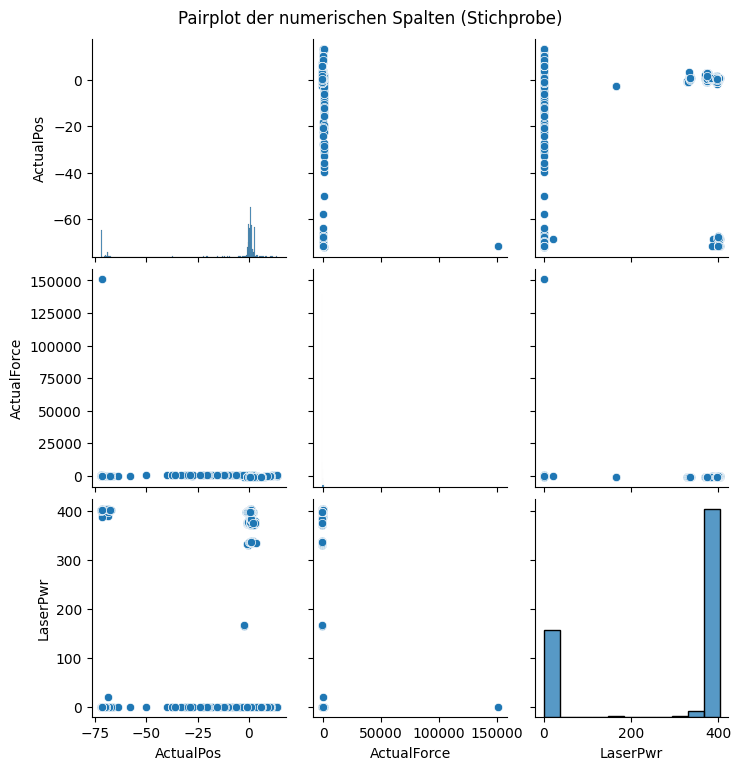

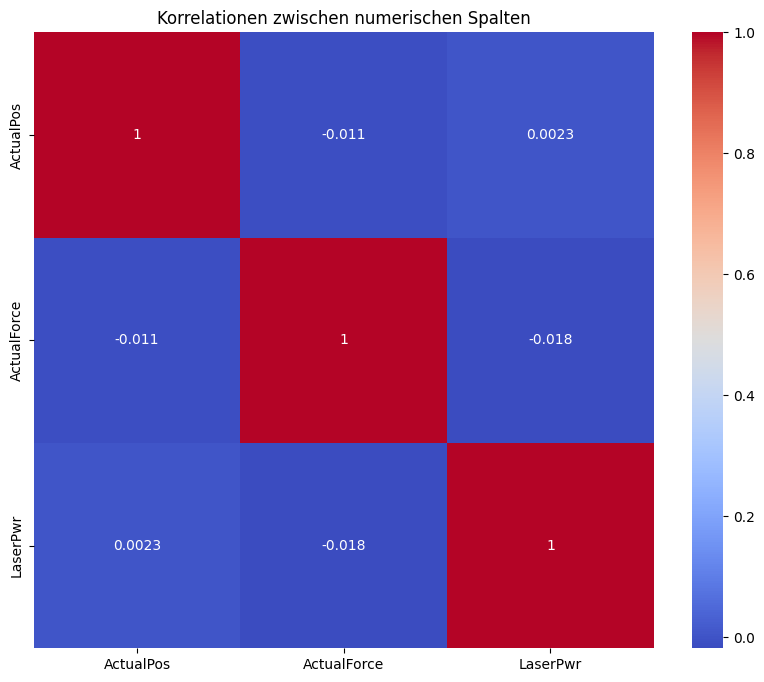

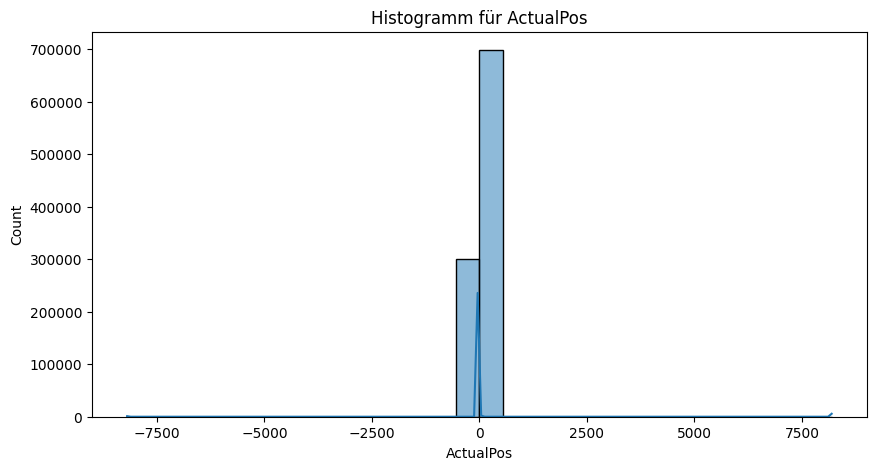

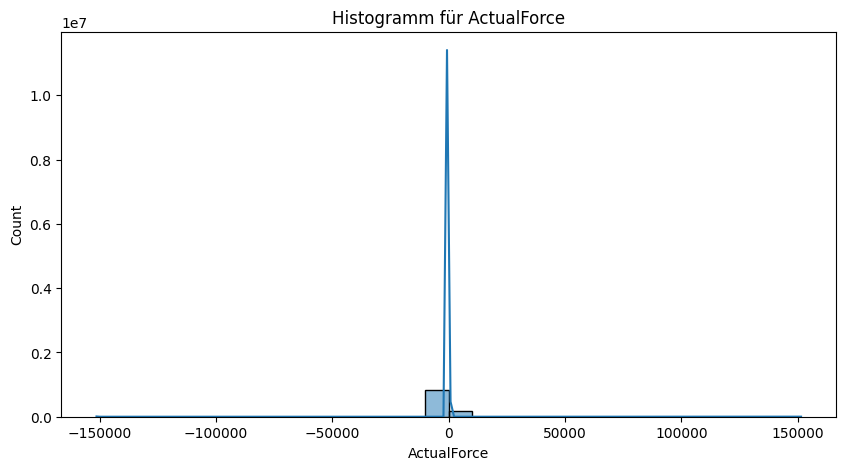

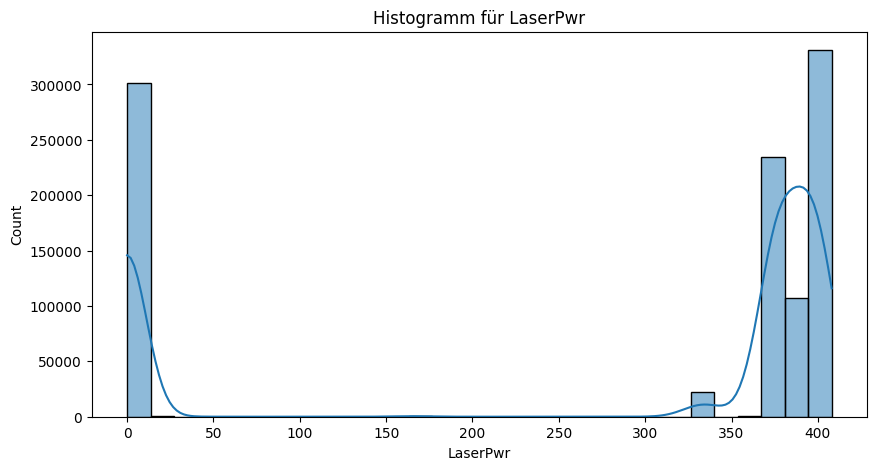


Anzahl der gefundenen Anomalien in der Stichprobe: 249


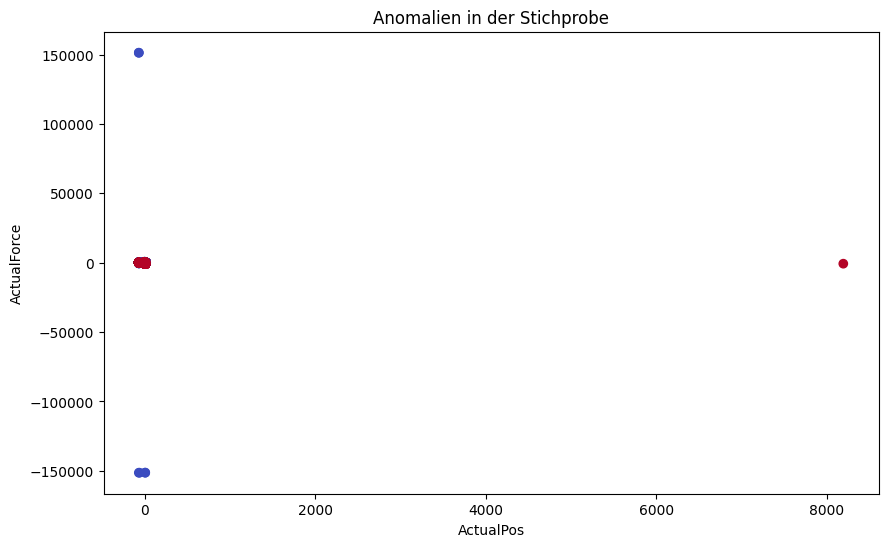

In [37]:
# Verbindung zur bereinigten SQLite-Datenbank herstellen
conn = sqlite3.connect('datenbank_clean.db')

# Tabelle aus der Datenbank lesen
clean_table_name = 'cleaned_data'
data = pd.read_sql(f"SELECT * FROM {clean_table_name}", conn)

# Verbindung schließen
conn.close()

# Prüfen, ob numerische Spalten vorhanden sind
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Methode 1: Stichprobe für Visualisierung
def visualize_sample(data, numerical_columns, sample_size=10000):
    if len(numerical_columns) > 0:
        sample_data = data.sample(n=sample_size, random_state=42)
        sns.pairplot(sample_data[numerical_columns])
        plt.suptitle("Pairplot der numerischen Spalten (Stichprobe)", y=1.02)
        plt.show()
    else:
        print("Keine numerischen Spalten für die Visualisierung gefunden.")

# Methode 2: Alternative Visualisierungen
def alternative_visualizations(data, numerical_columns):
    if len(numerical_columns) > 0:
        # Heatmap der Korrelationen
        plt.figure(figsize=(10, 8))
        sns.heatmap(data[numerical_columns].corr(), annot=True, cmap='coolwarm')
        plt.title("Korrelationen zwischen numerischen Spalten")
        plt.show()

        # Histogramme für numerische Spalten
        for column in numerical_columns:
            plt.figure(figsize=(10, 5))
            sns.histplot(data[column], bins=30, kde=True)
            plt.title(f"Histogramm für {column}")
            plt.show()
    else:
        print("Keine numerischen Spalten für alternative Visualisierungen gefunden.")

# Methode 3: Anomalieerkennung mit Isolation Forest
def detect_anomalies(data, numerical_columns, sample_size=5000, contamination=0.05):
    if len(numerical_columns) > 0:
        # Stichprobe für Anomalieerkennung
        sample_data = data.sample(n=sample_size, random_state=42)

        # Isolation Forest-Modell trainieren
        isolation_forest = IsolationForest(contamination=contamination, random_state=42)
        sample_data['anomaly'] = isolation_forest.fit_predict(sample_data[numerical_columns])

        # Anomalien markieren (-1 = Anomalie, 1 = normal)
        anomalies = sample_data[sample_data['anomaly'] == -1]
        print(f"\nAnzahl der gefundenen Anomalien in der Stichprobe: {len(anomalies)}")

        # Scatterplot der Anomalien (falls mindestens zwei numerische Spalten vorhanden sind)
        if len(numerical_columns) >= 2:
            plt.figure(figsize=(10, 6))
            plt.scatter(sample_data[numerical_columns[0]], sample_data[numerical_columns[1]], c=sample_data['anomaly'], cmap='coolwarm')
            plt.title("Anomalien in der Stichprobe")
            plt.xlabel(numerical_columns[0])
            plt.ylabel(numerical_columns[1])
            plt.show()
    else:
        print("Keine numerischen Spalten für die Anomalieerkennung gefunden.")

# Aufruf der Methoden
visualize_sample(data, numerical_columns, sample_size=1000)
alternative_visualizations(data, numerical_columns)
detect_anomalies(data, numerical_columns, sample_size=5000, contamination=0.05)

# 3. Visualisierung der Daten / Teil - 2

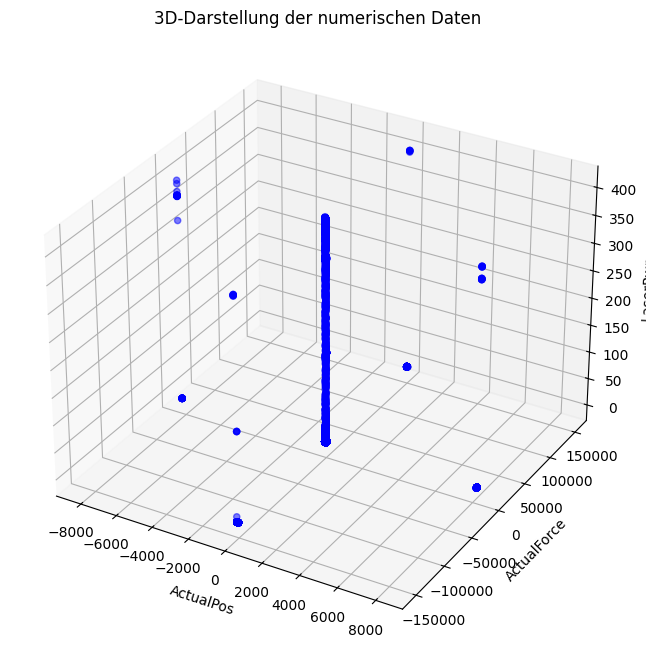

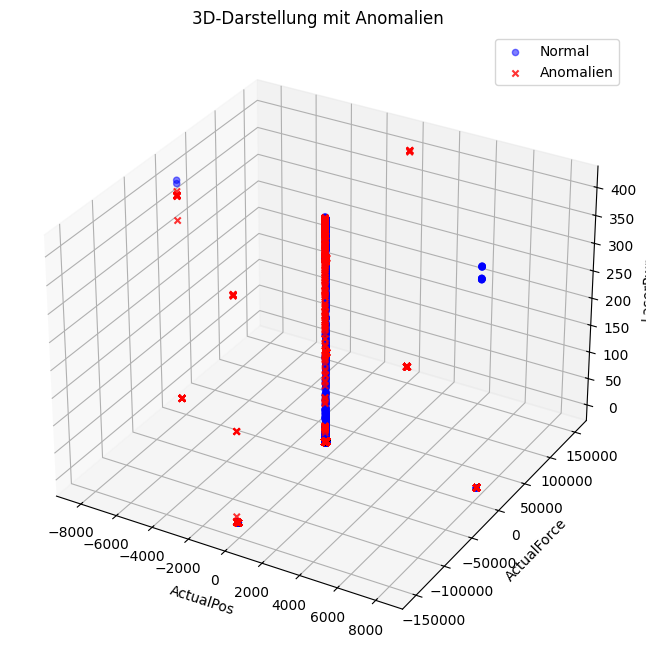

In [38]:
# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect('datenbank_clean.db')

# Tabelle mit bereinigten Daten laden
table_name = 'cleaned_data'
data = pd.read_sql(f"SELECT * FROM {table_name}", conn)

# Verbindung schließen
conn.close()

# Nur numerische Spalten auswählen
numeric_data = data.select_dtypes(include=[np.number])

# Überprüfen, ob mindestens drei numerische Spalten vorhanden sind
if numeric_data.shape[1] < 3:
    raise ValueError("Es werden mindestens drei numerische Spalten für die 3D-Darstellung benötigt.")

# Die ersten drei numerischen Spalten für die 3D-Darstellung auswählen
x_col, y_col, z_col = numeric_data.columns[:3]

# 3D-Plot der Daten
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(numeric_data[x_col], numeric_data[y_col], numeric_data[z_col], c='b', marker='o', alpha=0.5)
ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("3D-Darstellung der numerischen Daten")
plt.show()

# Anomalien mit IsolationForest erkennen
iso_forest = IsolationForest(contamination=0.05, random_state=42)
numeric_data['anomaly'] = iso_forest.fit_predict(numeric_data)

# Anomalien markieren
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalpunkte (anomaly = 1)
normal_data = numeric_data[numeric_data['anomaly'] == 1]
ax.scatter(normal_data[x_col], normal_data[y_col], normal_data[z_col], c='b', marker='o', alpha=0.5, label='Normal')

# Anomalien (anomaly = -1)
anomalies = numeric_data[numeric_data['anomaly'] == -1]
ax.scatter(anomalies[x_col], anomalies[y_col], anomalies[z_col], c='r', marker='x', alpha=0.8, label='Anomalien')

ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("3D-Darstellung mit Anomalien")
ax.legend()
plt.show()

# 3. Visualisierung der Daten / Teil - 3

Verfügbare Tabellen: [('cleaned_data',)]


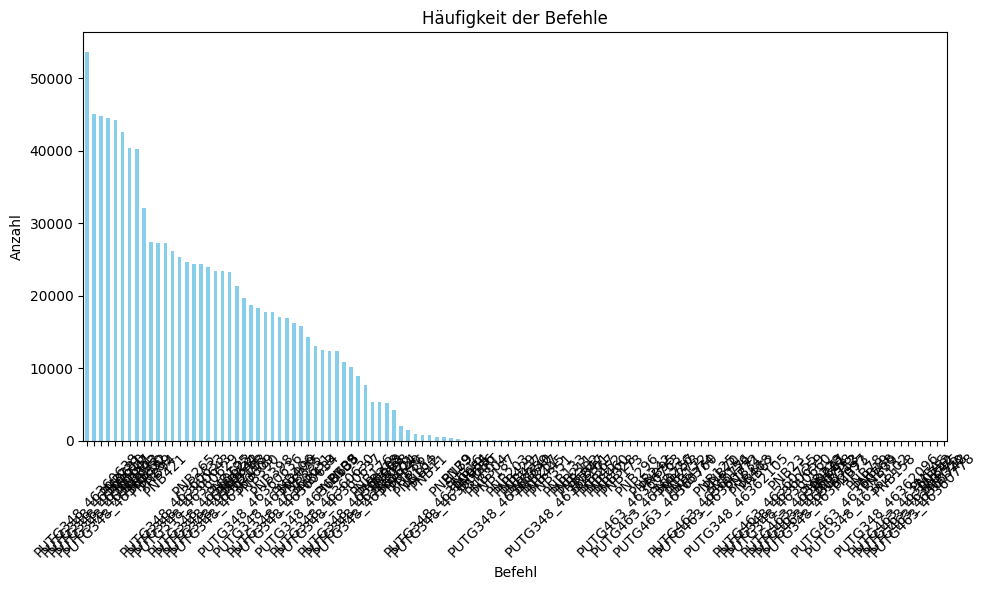

In [39]:
# Verbindung zur SQLite-Datenbank herstellen
db_path = 'datenbank_clean.db'
conn = sqlite3.connect(db_path)

# Tabellen in der Datenbank auflisten
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Verfügbare Tabellen:", tables)

# Daten aus der Tabelle 'bereinigte_daten' laden
query = "SELECT * FROM cleaned_data"  # Tabellennamen angepasst
df = pd.read_sql_query(query, conn)

# Überprüfen, ob die Spalte "Befehle" existiert
if 'Befehl' in df.columns:
    # Häufigkeitsanalyse der Spalte "Befehle"
    befehle_counts = df['Befehl'].value_counts()

    # Visualisierung: Balkendiagramm
    plt.figure(figsize=(10, 6))
    befehle_counts.plot(kind='bar', color='skyblue')
    plt.title('Häufigkeit der Befehle')
    plt.xlabel('Befehl')
    plt.ylabel('Anzahl')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Die Spalte 'Befehle' ist nicht in den Daten vorhanden.")

# Verbindung zur Datenbank schließen
conn.close()

# 3. Visualisierung der Daten / Teil - 4

Verfügbare Tabellen: [('cleaned_data',)]


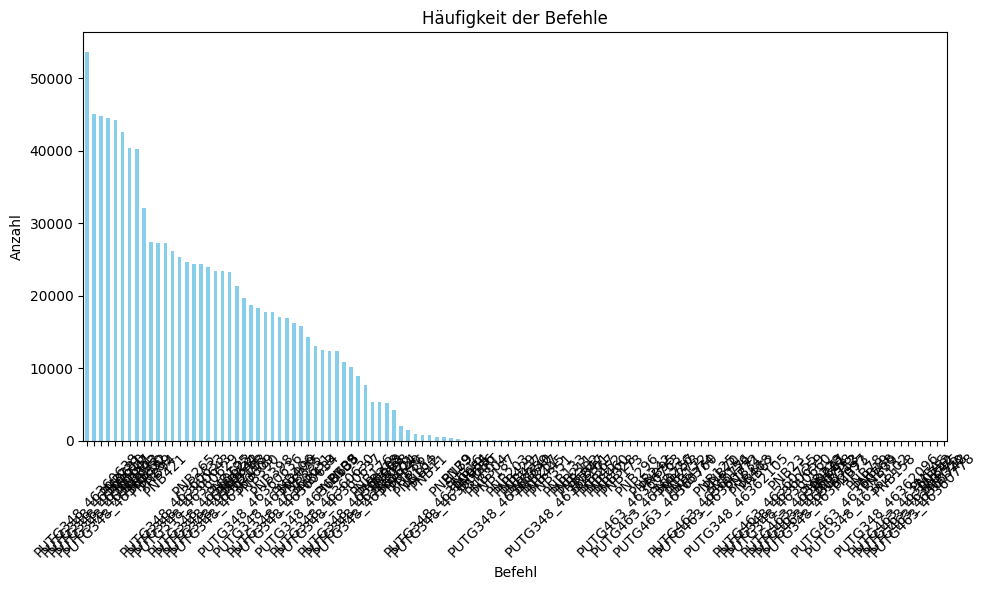

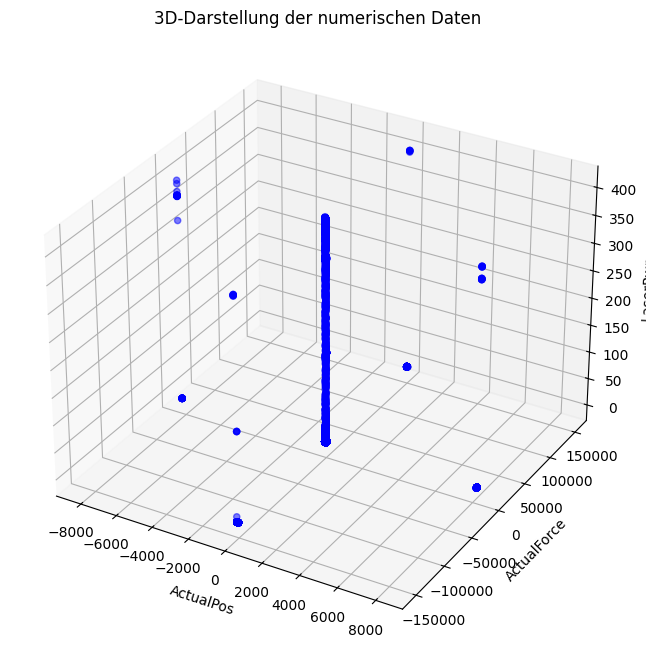

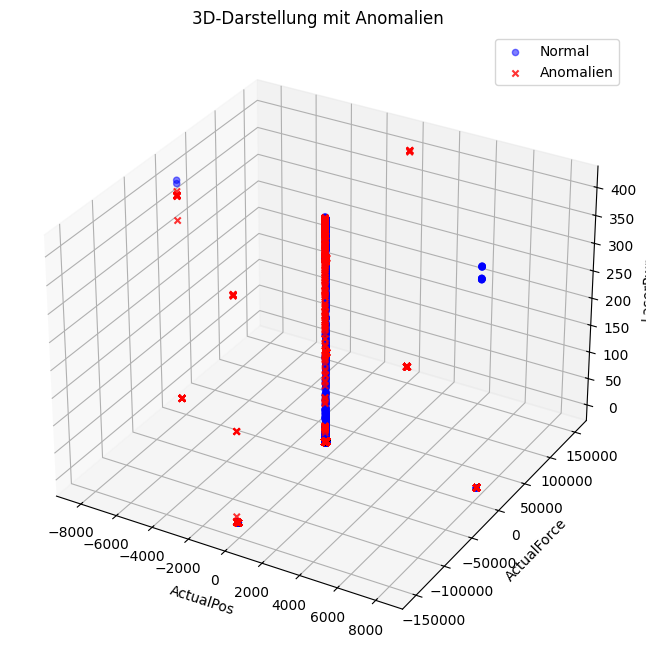

In [40]:
# Verbindung zur SQLite-Datenbank herstellen
db_path = 'datenbank_clean.db'
conn = sqlite3.connect(db_path)

# Tabellen in der Datenbank auflisten
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Verfügbare Tabellen:", tables)

# Daten aus der Tabelle 'bereinigte_daten' laden
table_name = 'cleaned_data'
data = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Überprüfen, ob die Spalte "Befehl" existiert
if 'Befehl' in data.columns:
    # Häufigkeitsanalyse der Spalte "Befehl"
    befehle_counts = data['Befehl'].value_counts()

    # Visualisierung: Balkendiagramm
    plt.figure(figsize=(10, 6))
    befehle_counts.plot(kind='bar', color='skyblue')
    plt.title('Häufigkeit der Befehle')
    plt.xlabel('Befehl')
    plt.ylabel('Anzahl')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Die Spalte 'Befehl' ist nicht in den Daten vorhanden.")

# Nur numerische Spalten auswählen
numeric_data = data.select_dtypes(include=[np.number])

# Überprüfen, ob mindestens drei numerische Spalten vorhanden sind
if numeric_data.shape[1] < 3:
    raise ValueError("Es werden mindestens drei numerische Spalten für die 3D-Darstellung benötigt.")

# Die ersten drei numerischen Spalten für die 3D-Darstellung auswählen
x_col, y_col, z_col = numeric_data.columns[:3]

# 3D-Plot der Daten
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(numeric_data[x_col], numeric_data[y_col], numeric_data[z_col], c='b', marker='o', alpha=0.5)
ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("3D-Darstellung der numerischen Daten")
plt.show()

# Anomalien mit IsolationForest erkennen
iso_forest = IsolationForest(contamination=0.05, random_state=42)
numeric_data['anomaly'] = iso_forest.fit_predict(numeric_data)

# Anomalien markieren
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalpunkte (anomaly = 1)
normal_data = numeric_data[numeric_data['anomaly'] == 1]
ax.scatter(normal_data[x_col], normal_data[y_col], normal_data[z_col], c='b', marker='o', alpha=0.5, label='Normal')

# Anomalien (anomaly = -1)
anomalies = numeric_data[numeric_data['anomaly'] == -1]
ax.scatter(anomalies[x_col], anomalies[y_col], anomalies[z_col], c='r', marker='x', alpha=0.8, label='Anomalien')

ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("3D-Darstellung mit Anomalien")
ax.legend()
plt.show()

# Verbindung zur Datenbank schließen
conn.close()

# 3. Visualisierung der Daten / Teil - 5

Verfügbare Tabellen: [('bereinigte_daten',)]


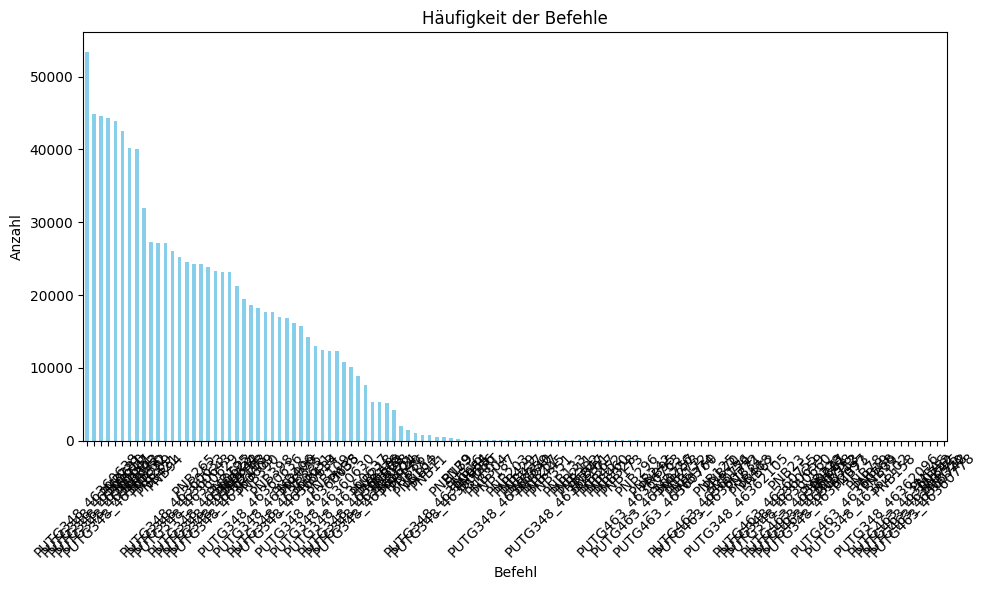

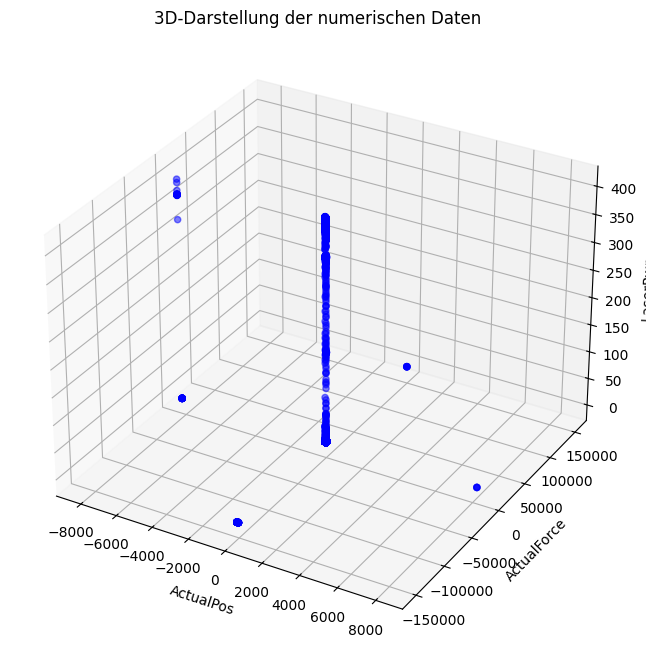

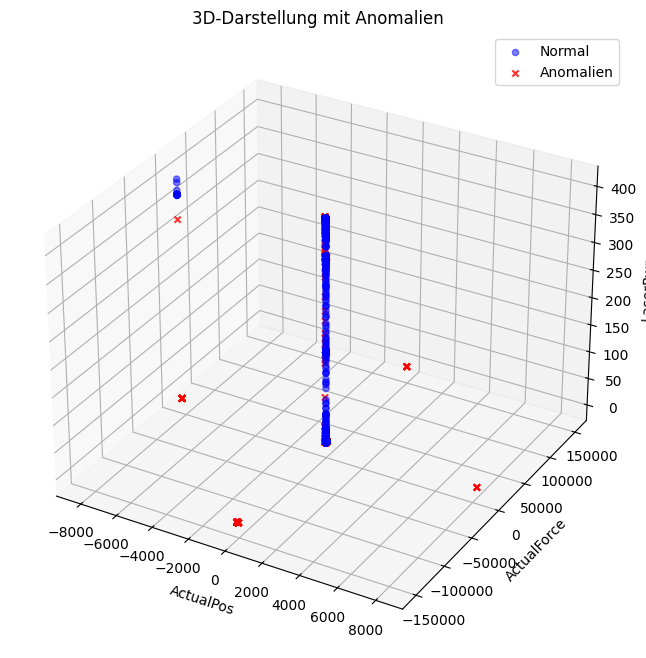

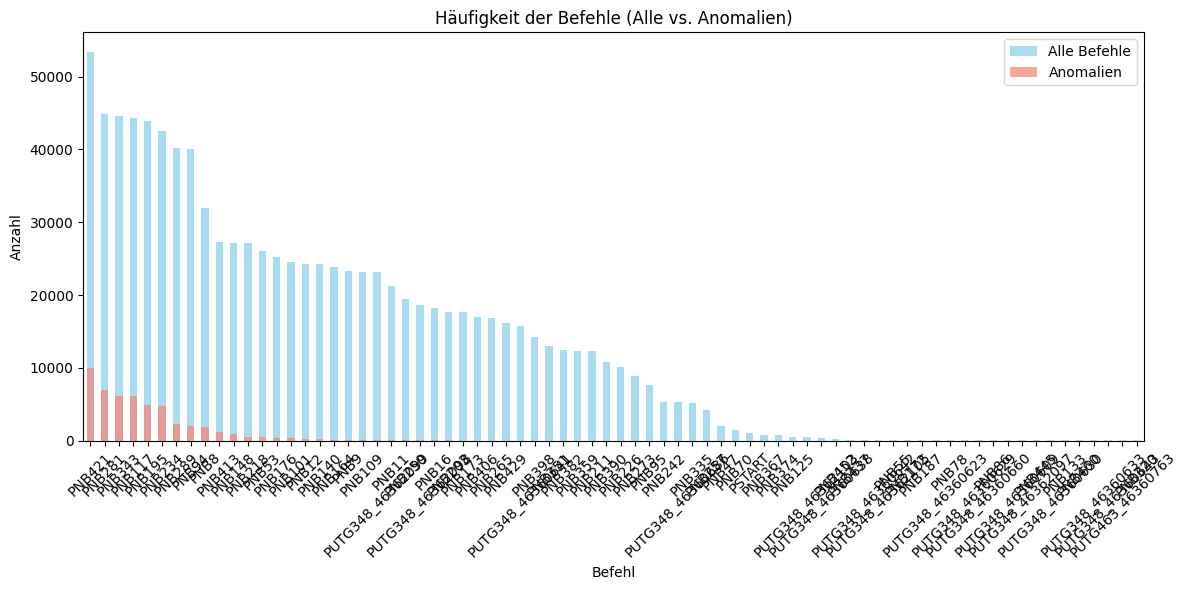

In [ ]:
# Verbindung zur SQLite-Datenbank herstellen
db_path = 'datenbank_clean.db'
conn = sqlite3.connect(db_path)

# Tabellen in der Datenbank auflisten
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Verfügbare Tabellen:", tables)

# Daten aus der Tabelle 'bereinigte_daten' laden
table_name = 'cleaned_data'
data = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Überprüfen, ob die Spalte "Befehl" existiert
if 'Befehl' in data.columns:
    # Häufigkeitsanalyse der Spalte "Befehl"
    befehle_counts = data['Befehl'].value_counts()

    # Visualisierung: Balkendiagramm
    plt.figure(figsize=(10, 6))
    befehle_counts.plot(kind='bar', color='skyblue')
    plt.title('Häufigkeit der Befehle')
    plt.xlabel('Befehl')
    plt.ylabel('Anzahl')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Die Spalte 'Befehl' ist nicht in den Daten vorhanden.")

# Nur numerische Spalten auswählen
numeric_data = data.select_dtypes(include=[np.number])

# Überprüfen, ob mindestens drei numerische Spalten vorhanden sind
if numeric_data.shape[1] < 3:
    raise ValueError("Es werden mindestens drei numerische Spalten für die 3D-Darstellung benötigt.")

# Die ersten drei numerischen Spalten für die 3D-Darstellung auswählen
x_col, y_col, z_col = numeric_data.columns[:3]

# 3D-Plot der Daten
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(numeric_data[x_col], numeric_data[y_col], numeric_data[z_col], c='b', marker='o', alpha=0.5)
ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("3D-Darstellung der numerischen Daten")
plt.show()

# Anomalien mit IsolationForest erkennen
iso_forest = IsolationForest(contamination=0.05, random_state=42)
numeric_data['anomaly'] = iso_forest.fit_predict(numeric_data)

# Anomalien markieren
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalpunkte (anomaly = 1)
normal_data = numeric_data[numeric_data['anomaly'] == 1]
ax.scatter(normal_data[x_col], normal_data[y_col], normal_data[z_col], c='b', marker='o', alpha=0.5, label='Normal')

# Anomalien (anomaly = -1)
anomalies = numeric_data[numeric_data['anomaly'] == -1]
ax.scatter(anomalies[x_col], anomalies[y_col], anomalies[z_col], c='r', marker='x', alpha=0.8, label='Anomalien')

ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("3D-Darstellung mit Anomalien")
ax.legend()
plt.show()

# Häufigkeitsanalyse der Befehle und Anomalien in einem Diagramm überlagern
if 'Befehl' in data.columns and 'anomaly' in numeric_data.columns:
    # Häufigkeitsanalyse der Befehle
    befehle_counts = data['Befehl'].value_counts()

    # Anomalien filtern und Häufigkeitsanalyse der Befehle in den Anomalien
    anomalies_data = data.loc[numeric_data['anomaly'] == -1]
    anomalies_befehle_counts = anomalies_data['Befehl'].value_counts() if not anomalies_data.empty else pd.Series()

    # Kombiniertes Balkendiagramm
    plt.figure(figsize=(12, 6))
    befehle_counts.plot(kind='bar', color='skyblue', label='Alle Befehle', alpha=0.7)
    if not anomalies_befehle_counts.empty:
        anomalies_befehle_counts.plot(kind='bar', color='salmon', label='Anomalien', alpha=0.7)

    plt.title('Häufigkeit der Befehle (Alle vs. Anomalien)')
    plt.xlabel('Befehl')
    plt.ylabel('Anzahl')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Die Spalte 'Befehl' oder 'anomaly' ist nicht in den Daten vorhanden.")

# Verbindung zur Datenbank schließen
conn.close()